# Adjoint-Based Optimization Framework for MIM Metasurface Absorbers

This notebook implements an adjoint-based inverse design framework for layered metal-insulator-metal (MIM) nanostructures using [Tidy3D](https://www.flexcompute.com/tidy3d/) as the electromagnetic simulator, `autograd` for gradient computation, and `optax` for optimization. The objective is to minimize reflectance (i.e., maximize absorption) at a designated wavelength across a defined spectral band.

**Author:** Fangru Lin 

**Institution:** University of Manchester 

**Project Start:** June 2024 

**Maintainers:** Dr Joel Loh Group 

**Special Thanks**  
Special thanks to **Yannick Augenstein** (Tidy3D) for his expert guidance on inverse design and his generous support throughout the initial development process, especially in debugging and sharing inverse design strategies.

## 1. Import Libraries, Define Constants and Materials

Load essential packages for simulation, optimization, automatic differentiation and visualization. 

Set up global constants such as wavelength ranges, material parameters and mesh resolution. Many of the parameters defined here are tightly coupled to specific design configurations (e.g., number of layers, material types). Users should carefully review and adapt these settings when modifying the structure to ensure consistency across parameter definitions and downstream usage in the code.

In [1]:
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library, Medium, Structure

import autograd
from autograd.tracer import getval
import autograd.numpy as anp
from typing import List, Tuple

import matplotlib.pylab as plt
import numpy as np
import os
import optax

In [2]:
Ni = material_library["Ni"]["RakicLorentzDrude1998"]  # Valid for 0.25 - 6.2 um
SiO2 = Medium(permittivity=2.08, name="SiO2")

bandwidth = 0.15  # microns
wvl_range = [3.30, 5.20]  # microns
freq_range = [td.C_0 / wvl_range[1], td.C_0 / wvl_range[0]]
wvl_points = 51  # Must be an odd number
wvls = anp.linspace(wvl_range[0], wvl_range[1], wvl_points)
freqs = np.flip(td.C_0 / wvls)

wvl0 = np.mean(wvl_range)
freq0 = td.C_0 / wvl0

print(f"Center frequency:\t{freq0: .2e} Hz")
print(f"Center wavelength:\t{wvl0} um")
print(f"Target bandwidth:\t{bandwidth} um")
print(f"Frequency range:\t[{freq_range[0]: .2e}, {freq_range[1]: .2e}] Hz")
print(f"Wavelength range:\t{wvl_range} um")

fwidth = freqs.max() - freqs.min()
run_time = 300 / fwidth
shutoff = 1e-4

print(f"\nSource frequency width:\t{fwidth: .2e} Hz")
print(f"Run time:\t\t{run_time: .2e} s")
print(f"Shutoff:\t\t{shutoff: .2e} W/m^2")

# only three freqs for now for async run

# monitor_freqs = [freqs[0], freqs[freqs.size // 2], freqs[-1]]
# monitor_wvls = [3.95, 4.10, 4.20, 4.25, 4.30, 4.35, 4.50, 4.80]
# monitor_wvls = [3.794, 3.946, 4.098, 4.193, 4.307]
# monitor_wvls = [4.25, 4.30]
# monitor_wvls = np.array([3.3, 3.338, 3.395, 3.604, 3.794, 4.098, 4.307, 4.402, 4.497, 4.592, 4.706, 4.801, 4.896, 4.953])
monitor_wvls = np.array([3.3, 3.395, 3.604, 3.794, 3.90, 3.95, 4.098, 4.15, 4.25, 4.32, 4.402, 4.497, 4.592, 4.706, 4.801, 4.953])
monitor_freqs = np.flip(td.constants.C_0 / monitor_wvls)
#monitor_wvls = np.array([3.642, 3.794, 3.946, 4.098, 4.193, 4.307, 4.497, 4.801])
#monitor_freqs = np.flip(td.constants.C_0 / monitor_wvls)
wvl_points = len(monitor_wvls)

print(f"\nMonitor frequency range: [{monitor_freqs[0]: .2e}, {monitor_freqs[-1]: .2e}] Hz")

buffer_size = 0.1  # distance between the source and the monitor
distance = wvl0  # distance between the source/monitor/structure and the PML

# Define the structure constraints
# Default substrate values
sub_metal_thickness = 0.2
sub_dielectric_thickness = 0.25
num_of_sub_layers = 2
# Substrate constraints
sub_metal_min_thickness = 0.1
sub_metal_max_thickness = 0.3
sub_dielectric_min_thickness = 0.15
sub_dielectric_max_thickness = 0.35
sub_thickness_constraints_min = [sub_metal_min_thickness, sub_dielectric_min_thickness]
sub_thickness_constraints_max = [sub_metal_max_thickness, sub_dielectric_max_thickness]

# Default cuboid values
cuboid_metal_thickneness = 0.025
cuboid_dielectric_thickness = 0.1
num_of_cuboid_layers = 2 * 5  # 5 bilayers
# Cuboid constraints
cuboid_min_length = 1.0
cuboid_max_length = 3.4
cuboid_min_width = 1.0
cuboid_max_width = 3.4
cuboid_metal_min_thickness = 0.015
cuboid_metal_max_thickness = 0.035
cuboid_dielectric_min_thickness = 0.05
cuboid_dielectric_max_thickness = 0.2
cuboid_thickness_constraints_min = [
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
]
cuboid_thickness_constraints_max = [
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
]

sub_materials = [Ni, SiO2]
cuboid_materials = [Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2]

# Simulation domain
Lx = 3.5
Ly = 3.5
Lz = (
    2 * wvl0
    + buffer_size
    + distance
    + sub_metal_max_thickness
    + sub_dielectric_max_thickness
    + 5 * (cuboid_metal_max_thickness + cuboid_dielectric_max_thickness)
)
min_steps_per_wvl = 10  # outside of structure
# fine discretization in propagation direction
# make sure to double-check discretization in xy
override_dl = (0.1, 0.1, 0.005)

Center frequency:	 7.05e+13 Hz
Center wavelength:	4.25 um
Target bandwidth:	0.15 um
Frequency range:	[ 5.77e+13,  9.08e+13] Hz
Wavelength range:	[3.3, 5.2] um

Source frequency width:	 3.32e+13 Hz
Run time:		 9.04e-12 s
Shutoff:		 1.00e-04 W/m^2

Monitor frequency range: [ 6.05e+13,  9.08e+13] Hz


## 2. Define Structure and Configure Simulation Environment

This section is responsible for constructing the parameterized geometry of the meta-atom and assembling it into a full electromagnetic simulation.

### 2.1 Create Parametric Structure

The `make_dynamic_structures` function generates a multi-layered metal-dielectric configuration based on the input design tuple:

| **Parameter Group** | **Description** |
| --- | --- |
| `sub_thicknesses` | Thicknesses of alternating substrate layers (e.g., metal/dielectric stack) | 
| `cuboid_thicknesses` | Thicknesses of cuboid bilayers above the substrate |
| `cuboid_length`, `cuboid_width` | Lateral size of the entire cuboid stack | 

Each parameter is clipped to its physical constraint range to ensure manufacturability. Tidy3D Simulation objects are then created for each layer and assembled into a full stack in the correct vertical (from bottom up) order.

In [4]:
def make_dynamic_structures(design_info: Tuple) -> List[Structure]:
    if design_info is None:
        return []

    sub_thicknesses, cuboid_thicknesses, cuboid_length, cuboid_width = design_info
    sub_thicknesses = anp.clip(sub_thicknesses, sub_thickness_constraints_min, sub_thickness_constraints_max)
    cuboid_thicknesses = anp.clip(cuboid_thicknesses, cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    cuboid_length = anp.clip(cuboid_length, cuboid_min_length, cuboid_max_length)
    cuboid_width = anp.clip(cuboid_width, cuboid_min_width, cuboid_max_width)

    # Substrate
    substrate = []
    z_center = -Lz / 2 + distance
    for i in range(num_of_sub_layers):
        z_center = z_center + sub_thicknesses[i] / 2 + (sub_thicknesses[i - 1] / 2 if i > 0 else 0)

        substrate.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(td.inf, td.inf, sub_thicknesses[i]),
                ),
                medium=sub_materials[i],
            )
        )

    z_center = z_center + sub_thicknesses[-1] / 2

    # Cuboid
    cuboid = []
    for i in range(num_of_cuboid_layers):
        z_center = (
            z_center + cuboid_thicknesses[i] / 2 + (cuboid_thicknesses[i - 1] / 2 if i > 0 else 0)
        )

        cuboid.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(cuboid_length[0], cuboid_width[0], cuboid_thicknesses[i]),
                ),
                medium=cuboid_materials[i],
            )
        )

    return substrate + cuboid

### 2.2 Define Source and Monitor

A normally incident Gaussian plane wave source is defined and positioned above the structure. Key features:
- Direction: -z (downward incidence)
- Center frequency: defined by the target design band
- Width: specified using `fwidth`
- Infinite spatial extent (in x-y plane)

Monitor objects are not yet added here—they will be defined dynamically later when constructing the objective function.

In [3]:
SOURCE_PLANEWV_NAME = "source_planewave"
FLUX_MONITOR_NAME = "monitor_flux"

source_planewave = td.PlaneWave(
    center=(0, 0, Lz / 2 - wvl0 - buffer_size),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    direction="-",
    pol_angle=0,
    name=SOURCE_PLANEWV_NAME,
)

### 2.3 Create Tidy3D Simulation Object

The `make_sim` function brings everything together into a fully defined `td.Simulation` object. This includes:
- Boundary conditions: periodic in x/y, PML in z
- Mesh specification: auto mesh based on minimum wavelength with a refined override in the structure region
- Geometry: inserted using `make_dynamic_structures`
- Source: Gaussian plane wave

An adaptive override mesh is added for improved accuracy in the z-direction, with bounds snapped to the nearest 0.1 µm (specified by `override_dl`) for consistency.

In [5]:
def make_sim(design_info: Tuple) -> td.Simulation:
    boundary_spec = td.BoundarySpec(
        x=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    dynamic_structures = make_dynamic_structures(design_info)

    # make mesh override, zmin and zmax are the bounds of the structure rounded down/up to the nearest 0.1
    zmin = np.floor(getval(dynamic_structures[0].geometry.bounds[0][2]) * 10) / 10
    zmax = np.ceil(getval(dynamic_structures[-1].geometry.bounds[1][2]) * 10) / 10
    override = td.MeshOverrideStructure(
        geometry=td.Box.from_bounds((-1e3, -1e3, zmin), (1e3, 1e3, zmax)),
        dl=override_dl,
        enforce=True,
    )

    grid_spec = td.GridSpec.auto(
        wavelength=min(wvl_range),  # always mesh for smallest wavelength
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[override],
    )

    sim = td.Simulation(
        center=(0, 0, 0),
        size=(Lx, Ly, Lz),
        run_time=run_time,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        structures=dynamic_structures,
        sources=[source_planewave],
        monitors=[],  # will be added in objective function
        shutoff=shutoff,
        symmetry=(-1, 1, 0),
    )

    return sim

### 2.4 Checkpoint

After the simulation object is created, a checkpoint step is run to ensure all parameters (geometry, materials and layout) look correct before entering the optimization stage. It will also give an estimated credit cost for each simulation. This is useful for verifying geometry clipping, symmetry enforcement and improper layer overlap before computational resources are committed.

In [6]:
def get_spectrum(time: np.array, data: np.array) -> np.array:
    fs = 1 / (time[1] - time[0])
    n = len(data)

    signal_fft = np.fft.fft(data)
    freqs = np.fft.fftfreq(n, 1 / fs)
    spectrum = np.abs(signal_fft)

    # Filter out small values
    threshold = np.max(spectrum) * 1e-3  # 0.1% of the maximum value
    spectrum[spectrum < threshold] = 0

    return freqs, spectrum

Values of random_design_info: (array([0.18719898, 0.10518525]), array([0.02599325, 0.02370645, 0.02340736, 0.0216067 , 0.01909297,
       0.02738542, 0.02099309, 0.02033655, 0.02742268, 0.02558284]), array([1.32299187]), array([2.23258749]))


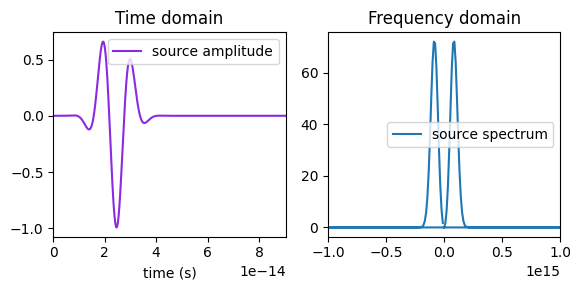

10:39:14 BST Created task 'week08_design_credit_estimation' with task_id        
             'fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=172197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=1243;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b\taskId]8;;\]8;id=172197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b\=]8;;\]8;id=201381;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b\fdve]8;;\]8;id=172197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b\-b7a5f559-210]8;;\
             ]8;id=172197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b7a5f559-2108-4470-8338-a7fc6c0b7b3b\8-4470-8338-a7fc6c0b7b3b']8;;\.

Output()

10:39:16 BST Maximum FlexCredit cost: 0.038. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Estimated cost: 0.03767501839801318


In [7]:
anp.random.seed(2)

random_sub_thicknesses = anp.random.uniform(
    sub_metal_min_thickness, sub_metal_max_thickness, num_of_sub_layers
)
random_cuboid_thicknesses = anp.random.uniform(
    cuboid_metal_min_thickness, cuboid_metal_max_thickness, num_of_cuboid_layers
)
random_cuboid_length = anp.random.uniform(cuboid_min_length, cuboid_max_length, 1)
random_cuboid_width = anp.random.uniform(cuboid_min_width, cuboid_max_width, 1)

random_design_info = (
    random_sub_thicknesses,
    random_cuboid_thicknesses,
    random_cuboid_length,
    random_cuboid_width,
)

print(f"Values of random_design_info: {random_design_info}")

random_sim = make_sim(random_design_info)

# Plot the source signal in time and frequency domain
times = np.arange(0, random_sim.run_time, random_sim.dt)
amplitudes = np.real(random_sim.sources[0].source_time.amp_time(times))

(fig, (ax_time, ax_freq)) = plt.subplots(1, 2, tight_layout=True, figsize=(6, 3))
ax_time = random_sim.sources[0].source_time.plot(
    times=np.linspace(0, random_sim.run_time / 100, 1001), ax=ax_time
)
ax_time.set_title("Time domain")
ax_time.set_xlim(0, random_sim.run_time / 100)
ax_time.legend(["source amplitude"])

line = ax_time.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()

freqs, spectrum = get_spectrum(x_data, y_data)
ax_freq.plot(freqs, spectrum)
ax_freq.set_title("Frequency domain")
ax_freq.set_xlim(-1e15, 1e15)
ax_freq.legend(["source spectrum", "measurement"])

plt.show()

# 3D plot of the random design
random_sim.plot_3d()
plt.show()

# Cost estimation for each simulation
job_random_sim = td.web.Job(
    simulation=random_sim, task_name="week08_design_credit_estimation", verbose=True
)
estimated_cost = td.web.estimate_cost(job_random_sim.task_id)
print(f"Estimated cost: {estimated_cost}")

## 3. Define Objective and Target Response

The goal of this optimization framework is to design a meta-atom structure that maximizes absorption (i.e., minimizes reflection) over a desired wavelength range. This is done by defining a target reflectance profile and minimizing the difference between the simulated and target response.

### 3.0 Optimization Philosophy

The objective function is constructed as:

$\text{Design Residue} = \mathcal{L} \left[ R_{\text{simulated}}(\lambda), R_{\text{target}}(\lambda) \right], \lambda \in \text{monitored wavelengths}$ 

Here:
- R_{\text{simulated}}(\lambda) is the reflection spectrum simulated by Tidy3D
- R_{\text{target}}(\lambda) is the desired spectral profile, e.g., from `target_gaussian()`
- \mathcal{L} is the loss function that measures deviation between simulated and target behavior

This high-level formula illustrates what kind of spectral behavior is desirable and supports gradient-based optimization using autograd.

### 3.1 Set Target Spectrum 

Two main types of target profiles are implemented:

- `target_square()`: Square (Flat-Band) Absorption
    This method defines an ideal absorber over a fixed bandwidth:
    - Reflectance = 0 inside the band
    - Reflectance = 1 outside the band

- `target_gaussian()`: Smooth Gaussian Dip
    This method creates a Gaussian-shaped dip in reflectance centered at a desired wavelength:
	- Reflectance = low at center (mu)
	- Reflectance = higher toward edges
	- Controlled by sigma (bandwidth) and peak depth

This notebook uses Gaussian dip as the ideal shape. 

Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40


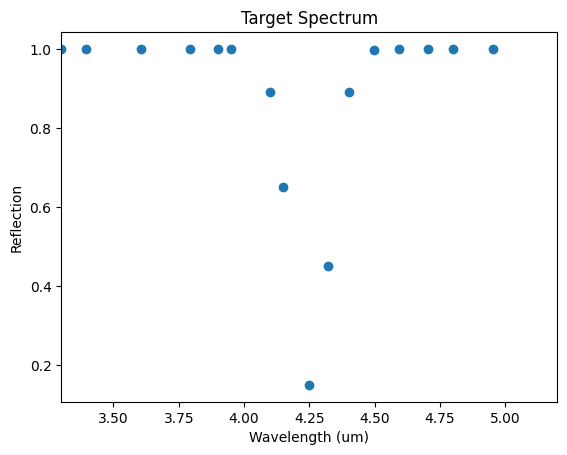

In [ ]:
def target_square() -> anp.array:
    wvl_min = wvl0 - bandwidth / 2.0
    wvl_max = wvl0 + bandwidth / 2.0
    print(f"wvl_min: {wvl_min: .2f}, wvl_max: {wvl_max: .2f}")
    return (wvls >= wvl_min) & (wvls <= wvl_max)

def target_gaussian(peak_value: float=0.85, mu: float=wvl0, sigma: float=bandwidth/2.0) -> anp.array:
    target = peak_value * anp.exp(-((monitor_wvls - mu) ** 2) / (2 * sigma ** 2))
    target = 1 - target
    print(f"Peak value: {peak_value:.2f}, mu: {mu:.2f}, sigma: {sigma:.2f}")
    print(f"wvl_min: {mu - 2*sigma:.2f}, wvl_max: {mu + 2*sigma:.2f}")
    return target

plt.scatter(monitor_wvls, target_gaussian())
# plt.scatter(monitor_wvls, target)
plt.xlim(wvl_range[0], wvl_range[1])
plt.xlabel("Wavelength (um)")
plt.ylabel("Reflection")
plt.title("Target Spectrum")
plt.show()

### 3.2 Choose Evaluation Functions 

Several error metrics for $\mathcal{L}$ are available, with each emphasizing on different metrics such as smooth penalties, robustness to outliers or emphasis on certain wavelengths. 

In [ ]:
def evaluate_flux_error_MAE(flux: anp.array) -> float: # Mean absolute error 
    target = target_gaussian()
    error = anp.sum(anp.abs(flux - target)) / wvl_points
    return error

def evaluate_flux_error_MSE(flux: anp.array) -> float: # Mean squared error
    diff2 = anp.abs(flux - target_gaussian()) ** 2
    error = anp.sum(diff2) / wvl_points
    return error

def evaluate_flux_error_weighted_MAE(flux: anp.array) -> float: # Weighted mean absolute error
    target = target_gaussian()
    weights = 1 / (target + 1)
    error = anp.sum(weights * anp.abs(flux - target)) / wvl_points
    return error

### 3.3 Objective Function Implementation and Batch Simulation

This section implements the core `objective_fn(params)` which:

1. Constructs a Tidy3D simulation object from the current design parameters  
2. Sets up multiple frequency-specific field monitors  
3. Runs a batch of single-frequency simulations asynchronously  
4. Extracts reflection data (flux values)  
5. Evaluates the objective function using a chosen error metric  

In [10]:
sim_data_history = []
fluxes_history = []

def generate_unique_task(base_path) -> Tuple[str, str]:
    i = 0
    while True:
        new_path = f"data/{base_path}_{i}.hdf5"
        new_name = f"task_{base_path}_{i}"
        if not os.path.exists(new_path):
            return new_name, new_path
        i += 1

def objective_fn(params) -> float:
    sim = make_sim(params)

    sims = {}
    for idx, freq in enumerate(monitor_freqs):
        # we run a separate simulation for each freq
        monitor_flux = td.FieldMonitor(
            center=(0, 0, Lz / 2 - wvl0),
            size=(td.inf, td.inf, 0),
            freqs=[freq],
            name=FLUX_MONITOR_NAME,
        )
        sims[f"flux_{idx}"] = sim.updated_copy(monitors=[monitor_flux])

    print(f"\tUploading batch simulation data...")

    batch_data = web.run_async(sims, verbose=False, path_dir="data")
    
    print(f"\tFinished batch simulation.")
    
    fluxes = [abs(batch_data[k][FLUX_MONITOR_NAME].flux.values.item()) for k in sims]
    error = evaluate_flux_error_weighted_MAE(fluxes)

    sim_data_history.append(batch_data)
    fluxes_history.append(fluxes)

    print(f"\tFinished objective function evaluation.")
    
    return error

## 4. Adjoint-Based Optimization

This is the core learning loop, where design parameters are iteratively updated using gradient-based optimization.

### 4.1 Initialization and First Evaluation

A scaled initial guess is constructed within the allowed bounds for all design variables (substrate and cuboid thicknesses, width and length). This guess is then simulated and visualized to validate the starting point.

The autograd-compatible function is defined as `val_and_grad_fn`. 

In [11]:
scaling_factor = 0.75

PARAMS0 = (
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(sub_thickness_constraints_min, sub_thickness_constraints_max)
    ]),
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    ]),
    anp.array([(cuboid_max_length - cuboid_min_length) * scaling_factor + cuboid_min_length]),
    anp.array([(cuboid_max_width - cuboid_min_width) * scaling_factor + cuboid_min_width],),
)

sim_initial = make_sim(PARAMS0)
sim_initial.plot_3d()
plt.show()

In [12]:
# Define the gradient function
val_and_grad_fn = autograd.value_and_grad(objective_fn)

In [13]:
%%script echo skip

val_initial, grad_initial = val_and_grad_fn(PARAMS0)
print(f"Initial design\tFlux error: {val_initial}\tGradient: {grad_initial}")

skip


Initial state visualization. No need to include, but written here for fun. 

In [14]:
# %%script echo skip

def plot_flux(itr: int):
    flux = [flux._value for flux in fluxes_history[-1]]
    plt.figure(figsize=(4, 2))
    plt.plot(monitor_wvls, flux)
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Flux")
    plt.title(f"Flux at iteration {itr}")
    plt.show()

In [15]:
%%script echo skip

plot_flux(0)

skip


### 4.2 Optimizer Setup and Shape Conversion

This is where the design is iteratively updated. In each iteration:

- Compute current flux error and gradients
- Optionally visualize reflectance spectrum
- Dynamically adjust step size based on loss magnitude
- Apply Adam updates using Optax
- Reconstruct structured design parameters
- Log the optimization history

To use optax with autograd, which are from different autodiff ecosystems (JAX vs. autograd), a manual flattening and reshaping mechanism is required:

Strategy:

1. Flatten the parameter tuple into a 1D numpy array
2. Perform gradient-based update using Optax (JAX-compatible)
3. Restore original shapes after update using np.split()

This ensures compatibility while retaining the flexibility of the autograd system used in `objective_fn`.

**Background Note**

At the time of development, Tidy3D supported JAX-based workflows, so this framework adopted JAX-compatible tools like optax for optimization. Later, Tidy3D shifted its backend toward autograd, which led to incompatibility between the gradient output and optimizer input types. Therefore, a manual conversion layer was introduced here. 

Iteration 1
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.2086161287477007


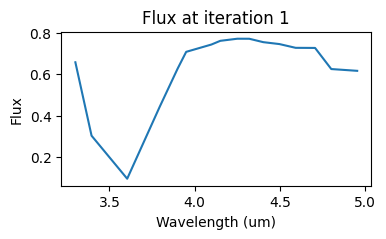

Iteration 2
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.23760048625667812


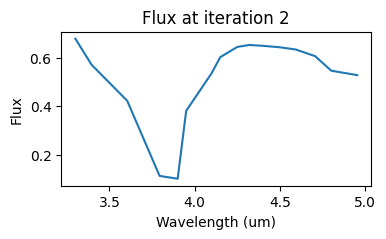

Iteration 3
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.2340766265526377


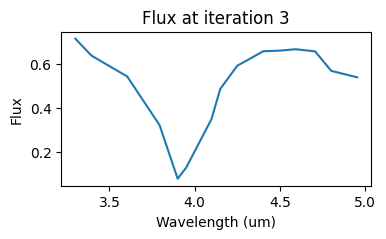

Iteration 4
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.23179470251031337


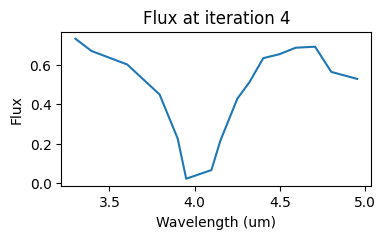

Iteration 5
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.19300631230820142


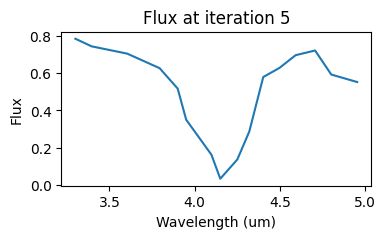

Iteration 6
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.19646348575077183


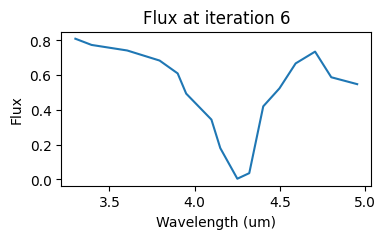

Iteration 7
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.19245332707499727


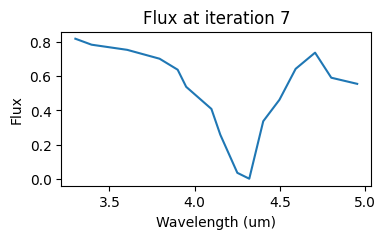

Iteration 8
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.1954001866134895


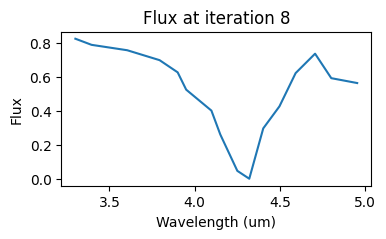

Iteration 9
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.19167060281324896


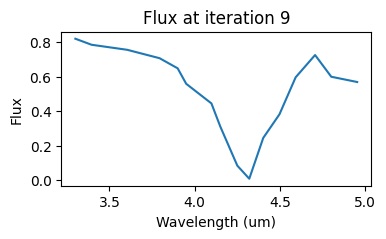

Iteration 10
	Uploading batch simulation data...
	Finished batch simulation.
Peak value: 0.85, mu: 4.25, sigma: 0.07
wvl_min: 4.10, wvl_max: 4.40
	Finished objective function evaluation.
	error value: 0.19718484148814142


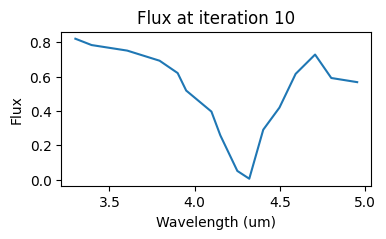

In [16]:
number_of_iterations = 10
step_size = 0.05
optimizer = optax.adam(learning_rate=step_size)
params_i = PARAMS0
shape = [p.size for p in params_i]
sim_i = make_sim(params_i) # Note that sim_i is a List of Simulation objects

optimizer_state = optimizer.init(np.concatenate(params_i))

params_history = [params_i]
error_history = []
grad_history = []
grad_norm_history = []

for i in range(number_of_iterations):
    print(f"Iteration {i + 1}")

    # Compute the value (error) and gradient of the objective function
    val_i, grad_i = val_and_grad_fn(params_i)
    # grad_norm_i = np.linalg.norm(grad_i)

    print(f"\terror value: {val_i}")

    # Visualize the iteration results
    plot_flux(i + 1)

    # Adjusting the step size as the optimization goes on
    step_size = val_i / 10.0
    optimizer = optax.adam(learning_rate=step_size)
    optimizer_state = optimizer.init(np.concatenate(params_i))

    params_i_concatenated = np.concatenate(params_i)
    grad_i_concatenated = np.concatenate(grad_i)

    # Update the parameters: error (loss) as small as possible
    updates, optimizer_state = optimizer.update(grad_i_concatenated, optimizer_state, params_i_concatenated)
    params_i_concatenated = optax.apply_updates(params_i_concatenated, updates) # params_i is now Jax-traced

    # Restore the original shape of the parameters
    params_i = np.array(params_i_concatenated)
    params_i = np.split(params_i, np.cumsum(shape[:-1]))

    # Save the optimization history
    params_history.append(params_i)
    error_history.append(val_i)
    grad_history.append(grad_i)
    # grad_norm_history.append(grad_norm_i)
    # Simulation data history is stored in sim_data_history in objective_fn

## 5. Result Visualization

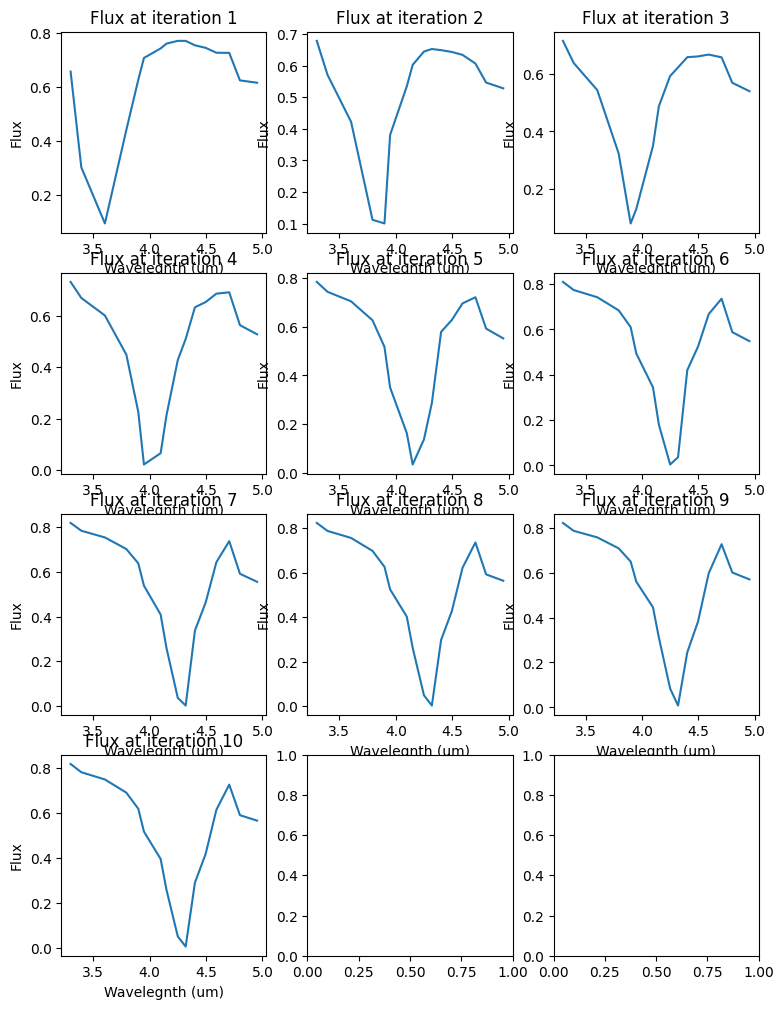

In [17]:
# Flux history

fig, axes = plt.subplots(4, 3, figsize = (9, 12))
axes = axes.flatten()
for i, flux in enumerate(fluxes_history):
    flux = [flux._value for flux in fluxes_history[i]]
    ax = axes[i]
    ax.plot(monitor_wvls, flux)
    ax.set_title(f'Flux at iteration {i+1}')
    ax.set_xlabel('Wavelegnth (um)')
    ax.set_ylabel('Flux')
# fig.delaxes(axes[-1]) # Delete the last subplot if number_of_iterations == 5
#plt.tight_layout()
plt.savefig("flux_history.png")
plt.show()

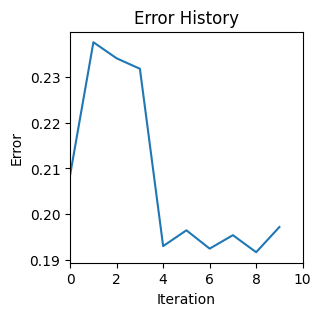

In [18]:
# Error history
plt.figure(figsize=(3, 3))
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.xlim((0, 10))
plt.title("Error History")
plt.show()

In [24]:
# Retrieve geometric parameters at the 8th iteration
itr = 5
wvl_points_for_checking = 101
wvls_for_checking = np.linspace(wvl_range[0], wvl_range[1], wvl_points_for_checking)
freqs_for_checking = np.flip(td.constants.C_0 / wvls_for_checking)

FLUX_MONITOR_FOR_CHECKING_NAME = 'flux_monitor_for_checking'

monitor_flux_for_checking = td.FluxMonitor(
    center=(0, 0, Lz / 2 - wvl0),
    size=(td.inf, td.inf, 0),
    freqs=freqs_for_checking,
    name=FLUX_MONITOR_FOR_CHECKING_NAME,
)

sim_for_checking = make_sim(params_history[itr-1])
sim_for_checking = sim_for_checking.updated_copy(monitors=[monitor_flux_for_checking])
sim_for_checking.plot_3d()

In [25]:
sim_data_for_checking = web.run(simulation=sim_for_checking, task_name='8th_iteration', path='data/8th_iteration.hdf5', verbose=False)

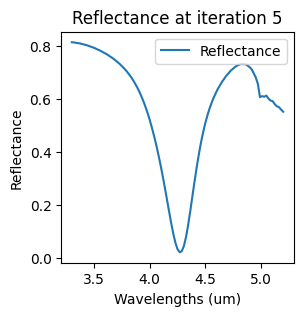

In [26]:
reflectance = sim_data_for_checking[FLUX_MONITOR_FOR_CHECKING_NAME].flux

plt.figure(figsize=(3, 3))
plt.plot(wvls_for_checking, reflectance, label='Reflectance')
plt.xlabel('Wavelengths (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at iteration {itr}')
plt.show()

In [22]:
%%script echo skip

sim_for_checking = make_sim(params_history[-1])
sim_for_checking = sim_for_checking.updated_copy(monitors=[monitor_flux_for_checking])
sim_data_for_checking = web.run(simulation=sim_for_checking, task_name='last_iteration', path='data/last_iteration.hdf5', verbose=False)

skip


In [23]:
%%script echo skip

reflectance = sim_data_for_checking[FLUX_MONITOR_FOR_CHECKING_NAME].flux

plt.figure(figsize=(3, 3))
# plt.scatter(wvls_for_checking, np.flip(reflectance))
plt.plot(wvls_for_checking, np.flip(reflectance), label='Reflectance')
plt.xlabel('Wavelength (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at iteration 10')
plt.show()

skip
